<a href="https://colab.research.google.com/github/balazs-vida/thesis/blob/master/vector_space_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A sample Vector Space Model pipeline
An illustration of mathematical processing of word--word matrices using the [Reuters Corpus](https://www.nltk.org/book/ch02.html). Adapted from [Assignment1 of CS224 ](http://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html) at Stanford University

#### Import libraries and dataset

In [1]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


#### Reading in corpus, building vocabulary

In [0]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category. Add START and END tokens to each of the documents, and lower-case words. 
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


In [3]:
reuters_corpus = read_corpus()
print("Example documents from the corpus")
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

Example documents from the corpus
[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', '

In [4]:
print("Number of documents in the corpus: ", len(reuters_corpus))

Number of documents in the corpus:  578


In [0]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    
    corpus_words = []
    num_corpus_words = -1
        
    corpus_words = sorted(list(set([y for x in corpus for y in x]))) #cf. https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python
    num_corpus_words = len(corpus_words)


    return corpus_words, num_corpus_words

In [6]:
corpus_words, num_corpus_words = distinct_words(reuters_corpus)
print("Number of unique words in the corpus: ", num_corpus_words)

Number of unique words in the corpus:  8185


#### Computing the word--word (co-occurrence) matrix


In [0]:
def compute_co_occurrence_matrix(corpus, window_size=4, tf_idf=True):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
            tf_idf (bool): whether to use tf_idf weighting of M
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    word2ind = {}
    transformer = TfidfTransformer(norm=None)
    
    corpus_words, num_corpus_words = distinct_words(corpus)
    M = np.zeros((num_corpus_words, num_corpus_words))
        
    
    # word2ind
    for counter, w in enumerate(corpus_words):
      word2ind[w] = counter
    
    # flatten corpus
    flattened_corpus = [y for x in corpus for y in x]
    
    # construct M
    for counter, w in enumerate(flattened_corpus):
      target_word_idx = word2ind[w]
      for i in range(-window_size, window_size+1):
        if i == 0 or counter+i < 0 or counter+i >= len(flattened_corpus): 
          continue
        else:
          context_word = flattened_corpus[counter+i]
          context_word_idx = word2ind[context_word]
          M[target_word_idx][context_word_idx] += 1

    # apply tf_idf
    if tf_idf:
      M = transformer.fit_transform(M).toarray()

    return M, word2ind

In [8]:
co_occurrence_mx, _ = compute_co_occurrence_matrix(reuters_corpus, window_size=4, tf_idf=True)
print("Shape of word--word matrix: ", co_occurrence_mx.shape)

Shape of word--word matrix:  (8185, 8185)


#### Dimensionality reduction using SVD

In [0]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [10]:
reduced_mx = reduce_to_k_dim(co_occurrence_mx, k=2)
print("Shape of reduced co-occurrence matrix: ", reduced_mx.shape)

Running Truncated SVD over 8185 words...
Done.
Shape of reduced co-occurrence matrix:  (8185, 2)


#### Plotting two-dimensional embeddings


In [0]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    
    x_coords = M_reduced[:0]
    y_coords = M_reduced[:1]

    for w in words:
      idx = word2ind[w]
      word_vec = M_reduced[idx]
      x = word_vec[0]
      y = word_vec[1]
      plt.scatter(x, y, marker='x', color='red')
      plt.text(x, y, w, fontsize=15)
    plt.show()

    # ------------------

Running Truncated SVD over 8185 words...
Done.


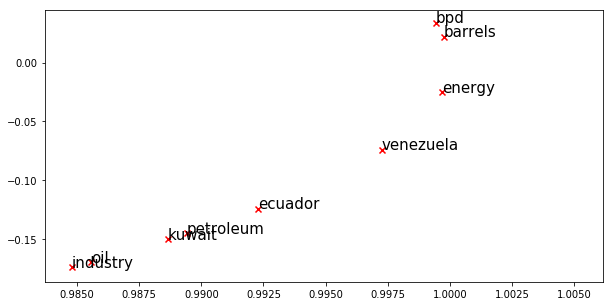

In [12]:
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### Word similarity

In [13]:
# produce rank-100 truncation of M
M_reduced_co_occurrence_100 = reduce_to_k_dim(M_co_occurrence, k=100)

Running Truncated SVD over 8185 words...
Done.


In [0]:
def get_word(word):
    """
    Get word vector for a given word
    
    Param:
           word (str)
    Return:
           word vector (numpy array)    
    """
    return M_reduced_co_occurrence_100[word2Ind_co_occurrence[word]]

In [0]:
def closest(word, n=10):
    """
    Find the n closest words for a given word. Uses cosine distance, which is (1 - cosine of the angle between vectors)
    
    Params:
           word (str)
           n (int)
    Return:
           numpy array of tuples of the form (word, cosine_distance), sorted in ascending order
    
    """
    all_dists = [(w, sp.spatial.distance.cosine(get_word(word), get_word(w))) for w in corpus_words]
    return sorted(all_dists, key=lambda t: t[1])[:n]

In [16]:
closest("oil")

[('oil', 0.0),
 ('most', 0.14952394265379898),
 ('supplies', 0.16626539495262171),
 ('increased', 0.1676720413101429),
 ('and', 0.17480472160447824),
 ('the', 0.18194254096788243),
 ('reduced', 0.18538108785735985),
 ('drilling', 0.1871515031751142),
 ('additional', 0.1875075682432924),
 ('lower', 0.18958714111544916)]

In [17]:
sp.spatial.distance.cosine(get_word("industry"), get_word("oil"))

0.3207010747790203